In [ ]:
!pip install -U fastai
!pip install efficientnet_pytorch

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path("/content/drive/My Drive/Dataset/")
path.ls()

(#30) [Path('/content/drive/My Drive/Dataset/test'),Path('/content/drive/My Drive/Dataset/valid'),Path('/content/drive/My Drive/Dataset/train'),Path('/content/drive/My Drive/Dataset/models'),Path('/content/drive/My Drive/Dataset/test_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/val_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/val_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/test_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/deployment'),Path('/content/drive/My Drive/Dataset/val_result_resnext101.csv')...]

In [ ]:
model_path = Path(path/'models')
train_path = Path(path/'train')

# Fastai image augmentation

(224, 224)


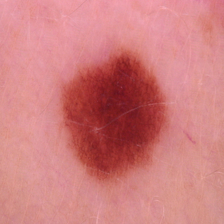

In [ ]:
img= Image.open(Path('//content/drive/My Drive/skin_cancer/train/benign/17.jpg'))
print(img.shape)
img

In [ ]:
image_path= Path('//content/drive/My Drive/skin_cancer/train/benign/17.jpg')
img = PILImage(PILImage.create(image_path).resize((224,224)))
img.shape, type(img)

((224, 224), fastai.vision.core.PILImage)

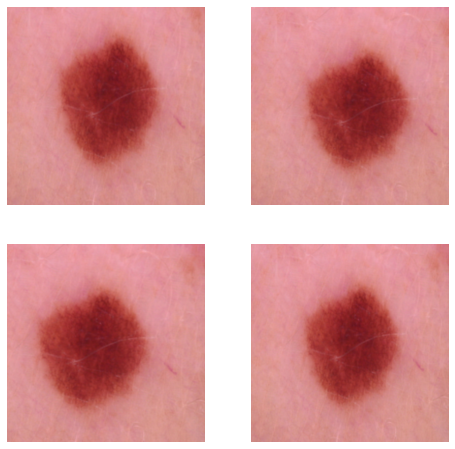

In [ ]:
# The crop picked as a random scale in range (min_scale,1)
crop = RandomResizedCrop(480, min_scale=0.8)
_,axs = plt.subplots(2,2,figsize=(8,8))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

### Compare the output image quality

In [ ]:
dataTry = ImageDataLoaders.from_folder(train_path, train='train', valid_pct=0, bs=32,)

In [ ]:
x,y = dataTry.one_batch()

In [ ]:
#collapse
def image_comp(x):
    tfms = setup_aug_tfms([Brightness(max_lighting=0.2, p=1.,),
                       Resize(size=256),
                       Zoom(max_zoom=1.5, p=1.),
                       Rotate(max_deg=10, p=1)
                      ])
    x = Pipeline(tfms)(x)

    x1 = TensorImage(x.clone())
    x1 = x1.affine_coord(sz=256)
    x1 = x1.brightness(max_lighting=0.2, p=1.)
    x1 = x1.zoom(max_zoom=1.5, p=1.)
    x1 = x1.rotate(max_deg=10, p=1)

    _,axs = subplots(1, 2, figsize=(10,10))
    TensorImage(x[0]).show(ctx=axs[0], title='fastai')
    TensorImage(x1[0]).show(ctx=axs[1], title='other')

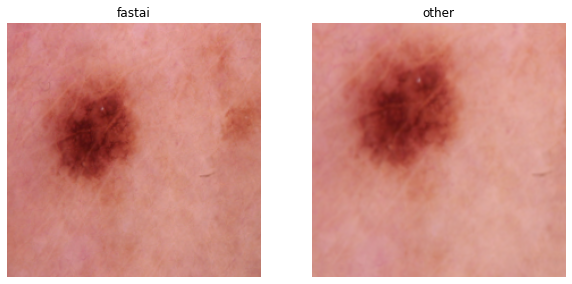

In [ ]:
image_comp(x)

The **fastai** data augmentation image is more clearer compared to the **other** augmentation image. 

### compare the spead of augmentation

In [ ]:
%%time
tfms = setup_aug_tfms([Brightness(max_lighting=0.2, p=1.,),
                    Resize(size=256),
                    Zoom(max_zoom=1.5, p=1.),
                    Rotate(max_deg=10, p=1)
                  ])
x = Pipeline(tfms)(x)
TensorImage(x[0]).show(ctx=axs[0])

CPU times: user 6.6 ms, sys: 943 µs, total: 7.54 ms
Wall time: 7.79 ms


In [ ]:
%%time
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=256)
x1 = x1.brightness(max_lighting=0.2, p=1.)
x1 = x1.zoom(max_zoom=1.5, p=1.)
x1 = x1.rotate(max_deg=10, p=1)
TensorImage(x1[0]).show(ctx=axs[0])

CPU times: user 12.2 ms, sys: 2.9 ms, total: 15.1 ms
Wall time: 15.1 ms


Comparing the times above using a pipeline where a list of transforms are passed in is 2-time faster than using augmentations step by step. 

In this case, the step by step method completed the task in 15.1 ms compard to 7.79 ms using fastai

# Data Loading

In [5]:
def get_data(img_size, bs):
  item_tfms = RandomResizedCrop(480, min_scale=0.80)
  batch_tfms = [*aug_transforms(size=img_size, max_rotate=15, flip_vert=True), Normalize()]

  data = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                      bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms)
  return data

In [6]:
data = get_data(224, 32)

In [ ]:
data.train_ds

(#2241) [(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1))...]

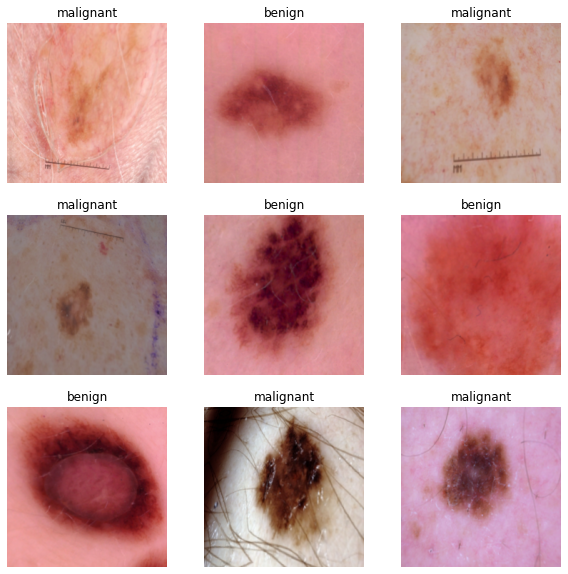

In [ ]:
data.show_batch(max_n=9, figsize=(10, 10))

In [8]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# EfficientNet-B0 

In [9]:
class connected_head_B0(nn.Module):
    def __init__(self):
      super(connected_head_B0, self).__init__()
      self.ConnectedLayer = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=1280, out_features=512, bias=True),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=512, out_features=data.c, bias=True))
      
    def forward(self, x):
      output = self.ConnectedLayer(x)
      return output

In [10]:
modelB0 = EfficientNet.from_pretrained('efficientnet-b0')
modelB0._fc = connected_head_B0()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


## Model training

In [11]:
effB0 = Learner(data, modelB0, opt_func=ranger, cbs=[ShowGraphCallback], path=path, metrics = [accuracy]).to_fp16()

In [ ]:
effB0.summary()

EfficientNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            64 x 3 x 226 x 226   0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ZeroPad2d            64 x 32 x 114 x 114  0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
Identity             64 x 32 x 1 x 1      0          False     
________________________________________________________________
Identity             64 x 8 x 1 x 1       0          False     
________________________________________________________________
Identity             64 x 32 x 112 x 112  0          False     
_______________________________________________

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=6.309573450380412e-07)

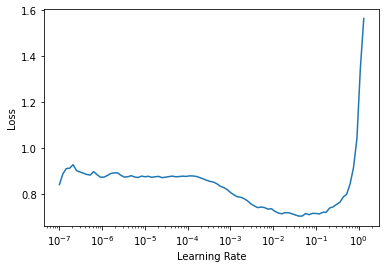

In [ ]:
effB0.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.180666,0.338283,0.863636,00:28


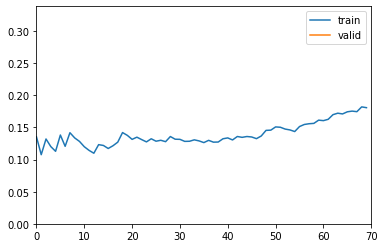

epoch,train_loss,valid_loss,accuracy,time
0,0.132366,0.281718,0.883838,00:28
1,0.137653,0.264207,0.906566,00:27
2,0.171996,0.262204,0.886364,00:27
3,0.201428,0.353518,0.866162,00:27
4,0.195512,0.389619,0.873737,00:27
5,0.182307,0.247671,0.901515,00:27
6,0.167849,0.329456,0.871212,00:27
7,0.151554,0.327074,0.886364,00:27
8,0.122355,0.314360,0.893939,00:28
9,0.106464,0.330643,0.873737,00:27


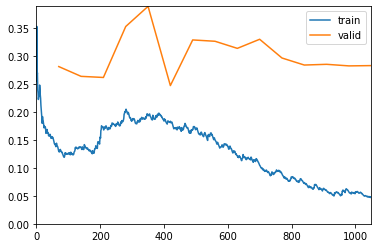

In [ ]:
effB0.fine_tune(15, 2e-3)

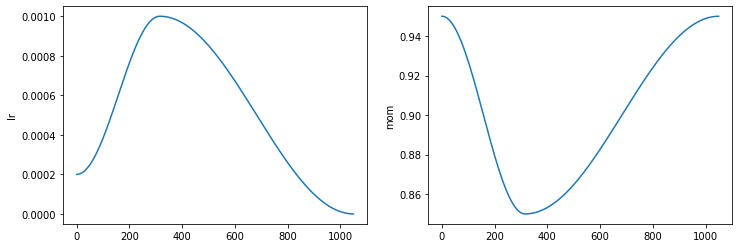

In [ ]:
effB0.recorder.plot_sched()

In [ ]:
effB0.save('effB0_224_1')

Path('/content/drive/My Drive/Dataset/models/effB0_224_1.pth')

## Observe missclassified images

In [12]:
effB0.load('effB0_224_1')

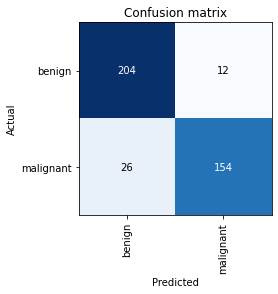

In [13]:
interp = ClassificationInterpretation.from_learner(effB0.to_fp16())
interp.plot_confusion_matrix()

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

      benign       0.89      0.94      0.91       216
   malignant       0.93      0.86      0.89       180

    accuracy                           0.90       396
   macro avg       0.91      0.90      0.90       396
weighted avg       0.91      0.90      0.90       396



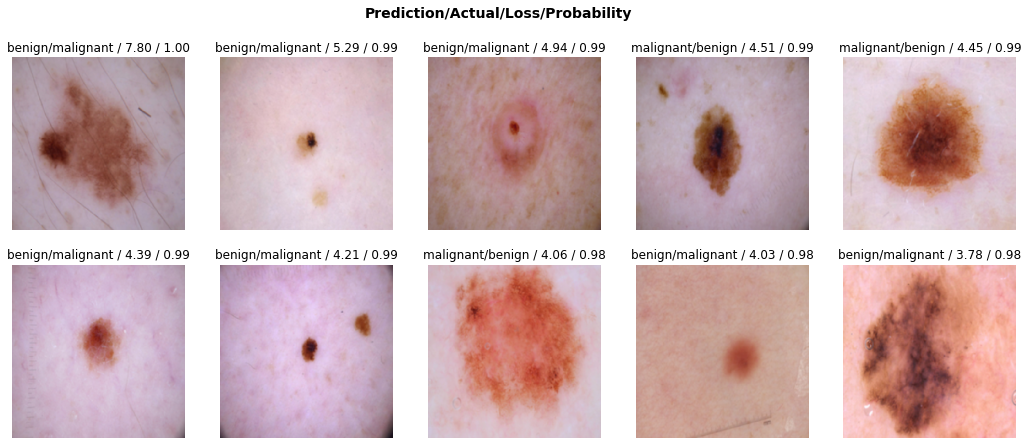

In [15]:
interp.plot_top_losses(10, nrows=2, ncols=5, figsize=(18,7))

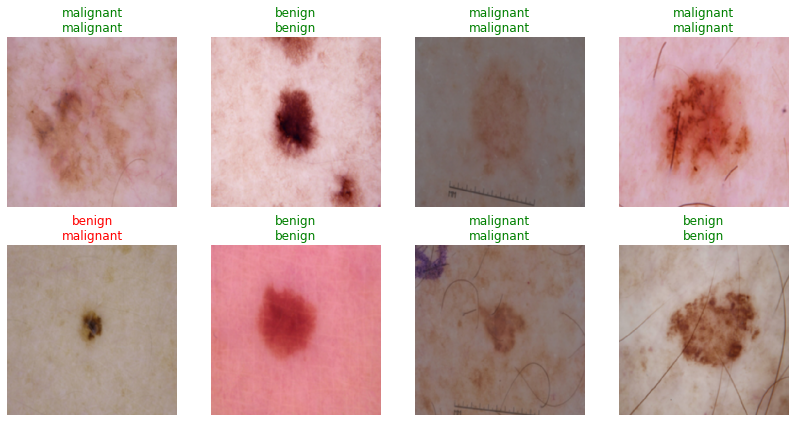

In [ ]:
effB5.show_results(max_n=8, nrows=2, ncols=4, figsize=(14,7))

# Evaluation on Testing data

In [16]:
test_path = Path(path/'test')
tst_fns = get_image_files(test_path)
# split label from Parent Folder
tst_lbl = [parent_label(fn) for fn in tst_fns]
dl = effB0.dls.test_dl(tst_fns, with_labels=True)

tst_lbl_num = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
tst_lbl_num[:10], tst_lbl_num[-10:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

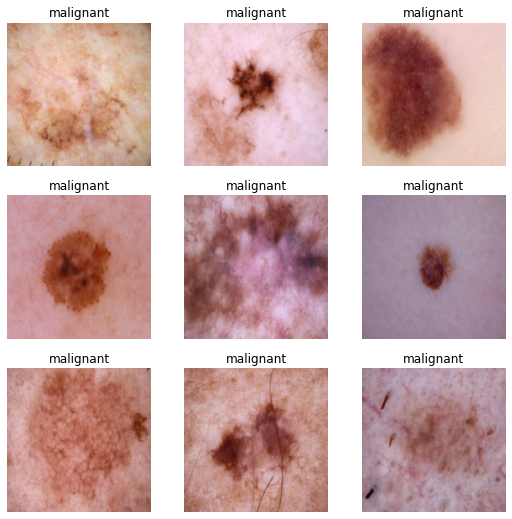

In [ ]:
dl.show_batch()

In [17]:
#preds, _ = effB0.tta(dl=dl)
preds, _ = effB0.get_preds(dl=dl)
preds_num = preds.argmax(1)
preds_num[:10], preds_num[-10:]

(TensorImage([1, 1, 1, 0, 1, 1, 1, 1, 1, 1]),
 TensorImage([0, 0, 0, 1, 0, 0, 0, 1, 0, 0]))

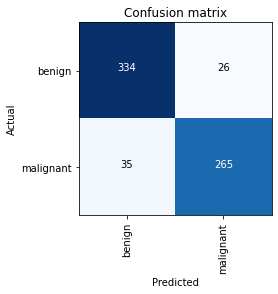

accuracy: 0.9075757575757576
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       360
           1       0.91      0.88      0.90       300

    accuracy                           0.91       660
   macro avg       0.91      0.91      0.91       660
weighted avg       0.91      0.91      0.91       660



In [18]:
cm = confusion_matrix(tst_lbl_num, preds_num)
plot_confusion_matrix(cm, data.vocab)

print('accuracy:',accuracy_score(tst_lbl_num, preds_num))
print(classification_report(tst_lbl_num, preds_num))

# Save Prediction

In [20]:
def get_model_prob_csv(model, dls, model_name):
  if dls == 'valid':
    val_path = Path(path/'valid')
    val_fns = get_image_files(val_path)
    val_lbl = [parent_label(fn) for fn in val_fns]
    Y_val = [0 if lbl == 'benign' else 1 for lbl in val_lbl]
    prob, _ = model.get_preds(dl=model.dls.valid)
    #Save Prediction in csv file
    df = pd.DataFrame({'val_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)),'y': Y_val})
    df.to_csv(path/"val_result_{}.csv".format(model_name), index=False)
    print('Validation dataframe created ...')

  elif dls == 'test':
    test_path = Path(path/'test')
    tst_fns = get_image_files(test_path)
    tst_lbl = [parent_label(fn) for fn in tst_fns]
    Y_test = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
    dl = model.dls.test_dl(tst_fns, with_labels=True)
    prob, _ = model.get_preds(dl=dl)
    #Save Prediction in csv file
    df = pd.DataFrame({'tet_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)), 'y': Y_test})
    df.to_csv(path/"test_result_{}.csv".format(model_name) , index=False)
    print('Test dataframe created ...')

In [21]:
get_model_prob_csv(model=effB0, dls='valid', model_name='effnetB0_notta')
get_model_prob_csv(model=effB0, dls='test', model_name='effnetB0_notta')

Validation dataframe created ...


Test dataframe created ...


In [22]:
## Download the csv files
valid_df = pd.read_csv(path/'val_result_effnetB0_notta.csv')
test_df = pd.read_csv(path/'test_result_effnetB0_notta.csv')

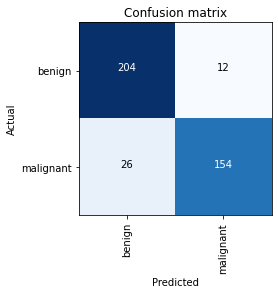

0.9040404040404041

In [23]:
cm = confusion_matrix(valid_df.y, valid_df.pred_y)
plot_confusion_matrix(cm, data.vocab)
accuracy_score(valid_df.y, valid_df.pred_y)

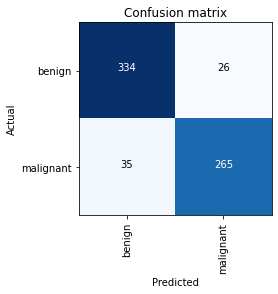

0.9075757575757576

In [24]:
cm = confusion_matrix(test_df.y, test_df.pred_y)
plot_confusion_matrix(cm, data.vocab)
accuracy_score(test_df.y, test_df.pred_y)

# Export model

In [ ]:
effB0.export('EfficientNetB0.pkl')

In [ ]:
path.ls(file_exts='.pkl')

(#2) [Path('/content/drive/My Drive/Dataset/resnet.pkl'),Path('/content/drive/My Drive/Dataset/EfficientNetB0.pkl')]